# Training Deep Neural Networks

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

2023-12-31 20:26:55.300213: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-31 20:26:55.448395: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-31 20:26:55.449266: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-31 20:26:56.605724: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## The Vanishing/Exploding Gradient Problems

### Galrot and He Initialization

By default, Keras uses Glorot initialization with a uniform distribution.
When creating a layer, we can change this to He initialization by setting
`kernel_initializer="he_uniform"` or
`kernel_initializer="he_normal"` like this:

In [4]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

If you want He initialization with a uniform distribution but based on
$fan_{avg}$ rather than $fan_{in}$, you can use the `VarianceScaling` initializer like
this:

In [5]:
he_avg_init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg', distribution='uniform')
keras.layers.Dense(10, activation="sigmoid", kernel_initializer=he_avg_init)

### Nonsaturating Activation Functions

To use the leaky ReLU activation function, create a `LeakyReLU` layer and
add it to our model just after the layer we want to apply it to:

In [6]:
model = keras.models.Sequential([
    keras.layers.Dense(10, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(alpha=0.2),
])

For SELU activation, `set activation="selu"` and
`kernel_initializer="lecun_normal"` when creating a layer:

In [7]:
layer = keras.layers.Dense(10, activation="selu", kernel_initializer="lecun_normal")

### Batch Normalization

In [8]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [9]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (Batch  (None, 784)               3136      
 Normalization)                                                  
                                                                 
 dense_4 (Dense)             (None, 300)               235500    
                                                                 
 batch_normalization_1 (Bat  (None, 300)               1200      
 chNormalization)                                                
                                                                 
 dense_5 (Dense)             (None, 100)               30100     
                                                                 
 batch_normalization_2 (Bat  (None, 100)              

As we can see, each BN layer adds four parameters per input: $\gamma$, $\beta$, $\mu$, and
$\sigma$ (for example, the first BN layer adds 3,136 parameters, which is 4 × 784). 
The last two parameters, $\mu$ and $\sigma$, are the moving averages; they are
not affected by backpropagation, so Keras calls them “non-trainable” 
(if we count the total number of BN parameters, 3,136 + 1,200 + 400, and
divide by 2, you get 2,368, which is the total number of non-trainable
parameters in this model).

**NOTE:**

$\mu$ and $\sigma$ are estimated during training, based on the training data, so arguably they
are trainable. In Keras, “non-trainable” really means “untouched by backpropagation.”

Let’s look at the parameters of the first BN layer. Two are trainable (by
backpropagation), and two are not:

In [10]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

The authors of the BN paper argued in favor of adding the BN layers
before the activation functions, rather than after (as we just did). But this highly depends on the task. To add the BN layers before the activation functions, you must
remove the activation function from the hidden layers and add them as
separate layers after the BN layers. Moreover, since a Batch
Normalization layer includes one offset parameter per input, you can
remove the bias term from the previous layer (just pass `use_bias=False`
when creating it):

In [11]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, kernel_initializer="he_normal",use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("elu"),
    keras.layers.Dense(100, kernel_initializer="he_normal",use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("elu"),
    keras.layers.Dense(10, activation="softmax")
])

When the input batch is 2D (i.e., the batch shape is `[batch size, features])`, this means that each input feature will be normalized based on the mean and standard deviation computed across all
the instances in the batch.

For example, the first BN layer in the previous code example will independently normalize (and rescale and shift) each of the 784 input features. If we move the first BN layer before the `Flatten` layer, then the input batches will be 3D, with shape `[batch size, height, width]`; therefore BN layer will compute 28 means and 28 standard deviations (1 per column of pixels, computed across all instances in the batch and across all rows in the column), and it will normalize all pixels in a given column using the same mean and standard deviation. There will also be just 28 scale parameters and 29 shift parameters. If instead we still want to treat each of the 784 pixels independently, then we should set `axis=[1,2]`

### Gradient Clipping

In Keras, implementing Gradient Clipping is just a matter of setting the
`clipvalue` or `clipnorm argument` when creating an optimizer, like this:

In [13]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss="mse", optimizer=optimizer)

The optimizier will clip every component of the gradient vector to a value between -1.0 and 1.0. This means that all the partial derivatives of the loss (wrt to each and every trainable parameter) will be clipped to -1.0 and 1.0. This threshold is a hyperparameter we can tune.

Note that, it may change the orientation of the gradient vector. For instance, if the original gradient vector is [0.9, 100.0], it points mostly in the direction of 2nd axis; but once u clip it by value, we get [0.9, 1.0], which points roughly in the diagonal between the two axes. In practice, this approach works well. 

If we want to ensure that Gradient Clipping does not change the direction of gradient vector, we should clip by norm by setting `clipnorm` instead of `clipvalue`. This will clip the whole gradient if its $l_2$ norm is greater than the threshold we picked. For example, if we set `clipnorm=1.0`, theb vector [0.9, 100.0] will be clipped to [0.00899964, 0.9999595], preserving its oreintation but almost eliminating its first component. 

## Reusing Pretrained Layers

### Transfer Learning with Keras

Suppose the Fashin MNIST dataset only contained eight classes -  for example, all the classes except for sandal and shirt. Someone built and trained a Keras model on that set and got reasonably good performance (>90% accuracy). Let's call this model A. Now we want to tackle a different task: we have images of sandals and shirts, and we want to train a binary classifier (positive = shirt, negative = sandal). Our dataset is quite small, we only have 200 labelled images. When we train a new model for this task (let's call it model B) with the same architecture as model A, it performs reasonably well (97.2 % accuracy). But since it's a much easier task (there are just two classes), we were hoping for more. While drinking our morning coffee, we realized that our task is quite similar to task A, so perhaps transfer learning can help. Let's find out.

But first of all we will train model A, so that we can reuse it.

##### Training Model A

Let's split the Fashion MNIST dataset in two:

- `X_train_A`: all the images of all items except for sandalas and shirts (class 5 and 6)
- `X_train_B`: a smaller training set of just 200 images of sandalas and shirts

The validation and test set are also split this way, but without restricting the number of images. 

In [41]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) #binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

In [42]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [43]:
(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [7]:
X_train_A.shape

(43986, 28, 28)

In [8]:
X_train_B.shape

(200, 28, 28)

In [9]:
y_train_A[:30]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3, 4, 5,
       1, 3, 4, 2, 0, 6, 7, 1], dtype=uint8)

In [10]:
y_train_B[:30]

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

In [11]:
tf.random.set_seed(42)
np.random.seed(42)

In [12]:
keras.backend.clear_session()

In [13]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [14]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [15]:
history = model_A.fit(X_train_A, y_train_A, epochs=20, validation_data=(X_valid_A, y_valid_A))

Epoch 1/20


2023-12-26 21:18:06.510259: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 137940096 exceeds 10% of free system memory.


1375/1375 [==============================] - 3s 2ms/step - loss: 0.5725 - accuracy: 0.8144 - val_loss: 0.3817 - val_accuracy: 0.8717
Epoch 2/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.3495 - accuracy: 0.8798 - val_loss: 0.3242 - val_accuracy: 0.8916
Epoch 3/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.3144 - accuracy: 0.8913 - val_loss: 0.2977 - val_accuracy: 0.8996
Epoch 4/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.2958 - accuracy: 0.8971 - val_loss: 0.2849 - val_accuracy: 0.9081
Epoch 5/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2832 - accuracy: 0.9016 - val_loss: 0.2743 - val_accuracy: 0.9108
Epoch 6/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2736 - accuracy: 0.9054 - val_loss: 0.2704 - val_accuracy: 0.9066
Epoch 7/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2658 - accuracy: 0.9092 - val_loss: 0.2647 - val_accuracy: 0.9108
Epo

In [16]:
model_A.save("my_model_A.h5")

/home/dell/anaconda3/envs/latest/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Now we will train model_B (binary classifier) from and then we will train using transfer learning and then we will check whether transfer learning provides any benefits:

##### Training Model B from scratch

In [17]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [18]:
model_B.compile(loss="binary_crossentropy",
               optimizer=keras.optimizers.SGD(learning_rate=1e-3),
               metrics=["accuracy"])

In [19]:
history = model_B.fit(X_train_B, y_train_B, epochs=20, 
                     validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 1s 59ms/step - loss: 0.7185 - accuracy: 0.6000 - val_loss: 0.5737 - val_accuracy: 0.6673
Epoch 2/20
7/7 [==============================] - 0s 14ms/step - loss: 0.5255 - accuracy: 0.7600 - val_loss: 0.4362 - val_accuracy: 0.8347
Epoch 3/20
7/7 [==============================] - 0s 14ms/step - loss: 0.3989 - accuracy: 0.8750 - val_loss: 0.3527 - val_accuracy: 0.8925
Epoch 4/20
7/7 [==============================] - 0s 18ms/step - loss: 0.3214 - accuracy: 0.9050 - val_loss: 0.2962 - val_accuracy: 0.9168
Epoch 5/20
7/7 [==============================] - 0s 15ms/step - loss: 0.2666 - accuracy: 0.9350 - val_loss: 0.2559 - val_accuracy: 0.9391
Epoch 6/20
7/7 [==============================] - 0s 15ms/step - loss: 0.2261 - accuracy: 0.9600 - val_loss: 0.2257 - val_accuracy: 0.9493
Epoch 7/20
7/7 [==============================] - 0s 16ms/step - loss: 0.1982 - accuracy: 0.9650 - val_loss: 0.2038 - val_accuracy: 0.9544
Epoch 8/20
7/7 [===========

In [20]:
model_B.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 300)               235500    
                                                                 
 dense_7 (Dense)             (None, 100)               30100     
                                                                 
 dense_8 (Dense)             (None, 50)                5050      
                                                                 
 dense_9 (Dense)             (None, 50)                2550      
                                                                 
 dense_10 (Dense)            (None, 50)                2550      
                                                                 
 dense_11 (Dense)            (None, 1)                

Now let's use the transfer learning. 

First we need to load model A and create a new model based on that model's layers. Let's reuse all the layers except for the output layer:

In [21]:
model_A = keras.models.load_model("my_model_A.h5")

In [22]:
model_A.layers

In [23]:
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

Note that `model_A` and `model_B_on_A` now share some layers. When we train `model_B_on_A`, it will also affect `model_A`. If we want to avoid that, we need to clone the `model_A` before we reuse its layers. To do this, we clone model A's architecture with `clone.model()`, then copy its weights (since `clone_model()` does not clone the weights):

In [24]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

In [25]:
model_B_on_A = keras.models.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

Now we could train `model_B_on_A` for task B, but since the new output layer was initialized randomly it will make large errors (at least during the first few epochs), so there will be large error gradients that may wreck the reused weights. To avoid this, one approach is to freeze the reused layers during the first few epochs, giving the new layer some time to learn reasonable weights. 

To do this, set every layer's `trainable` attribute to `False` and compile the model:

In [26]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

In [27]:
model_B_on_A.compile(loss="binary_crossentropy", 
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3), 
                     metrics=["accuracy"])

**NOTE:**

We must always compile our model after we freeze or unfreeze layers.

Now we can train the model for a few epochs, then unfreeze the reused layers (which requires compiling the model again) and continue training to fine-tune the reused layers for task B. After unfreezing the reused layers, it is usually good idea to reduce the learning rate, once again to avoid damaging the reused weights.

In [28]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4, validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 1s 37ms/step - loss: 0.8463 - accuracy: 0.4500 - val_loss: 0.7631 - val_accuracy: 0.5101
Epoch 2/4
7/7 [==============================] - 0s 13ms/step - loss: 0.7725 - accuracy: 0.5200 - val_loss: 0.6979 - val_accuracy: 0.5659
Epoch 3/4
7/7 [==============================] - 0s 15ms/step - loss: 0.7047 - accuracy: 0.5800 - val_loss: 0.6425 - val_accuracy: 0.6258
Epoch 4/4
7/7 [==============================] - 0s 14ms/step - loss: 0.6471 - accuracy: 0.6250 - val_loss: 0.5951 - val_accuracy: 0.6805


In [29]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

In [30]:
optimizer = keras.optimizers.SGD(learning_rate = 1e-3)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [31]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16, validation_data=(X_valid_B, y_valid_B))

Epoch 1/16
7/7 [==============================] - 1s 38ms/step - loss: 0.5373 - accuracy: 0.7250 - val_loss: 0.4243 - val_accuracy: 0.8276
Epoch 2/16
7/7 [==============================] - 0s 13ms/step - loss: 0.3924 - accuracy: 0.8550 - val_loss: 0.3262 - val_accuracy: 0.9249
Epoch 3/16
7/7 [==============================] - 0s 13ms/step - loss: 0.3027 - accuracy: 0.9200 - val_loss: 0.2662 - val_accuracy: 0.9554
Epoch 4/16
7/7 [==============================] - 0s 14ms/step - loss: 0.2468 - accuracy: 0.9550 - val_loss: 0.2258 - val_accuracy: 0.9635
Epoch 5/16
7/7 [==============================] - 0s 15ms/step - loss: 0.2085 - accuracy: 0.9750 - val_loss: 0.1953 - val_accuracy: 0.9746
Epoch 6/16
7/7 [==============================] - 0s 15ms/step - loss: 0.1787 - accuracy: 0.9850 - val_loss: 0.1728 - val_accuracy: 0.9787
Epoch 7/16
7/7 [==============================] - 0s 14ms/step - loss: 0.1572 - accuracy: 0.9850 - val_loss: 0.1560 - val_accuracy: 0.9817
Epoch 8/16
7/7 [===========

In [32]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.0902 - accuracy: 0.9875


[0.0902191549539566, 0.987500011920929]

In [33]:
model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.0965 - accuracy: 0.9815


[0.09650509804487228, 0.9815000295639038]

Well the model's test accuracy has improved a little bit from transfer learning. 

It turns out that transfer learning does not work very well with small dense networks, preasumably because small networks learn few patterns, and dense networks learn very specific patterns, which are unlikely to be useful in other tasks. Transfer learning works best with deep CNN, which tend to learn feature detectors that are much more general (especially in the lower layers).

### Unsupervised Pretraining

### Pretraining on Auxiliary Task

## Faster Optimizers

### Momentum Optimization

Implementing momentum optimization in Keras is a no-brainer: just use
the SGD optimizer and set its `momentum` hyperparameter, then lie back and
profit!

In [2]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

### Nesterov Accelerated Gradient (NAG)

NAG is generally faster than regular momentum optimization. To use it simply set `nesterov=True` when creating SGD optimizer:

In [3]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

### AdaGrad

In [4]:
optimizer = keras.optimizers.Adagrad(learning_rate=0.001)

### RMSProp

In [6]:
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

### Adam and Nadam Optimization

The momentum decay hyperparameter $\beta_1$ is typically initialized to 0.9,
while the scaling decay hyperparameter $\beta_2$ is often initialized to 0.999. As
earlier, the smoothing term $\epsilon$ is usually initialized to a tiny number such as
$10^{-7}$.

These are the default values for the `Adam` class (to be precise, `epsilon` defaults to `None`, which tells Keras to use `keras.backend.epsilon()`, which defaults to $10^{-7}$; we can change it
using `keras.backend.set_epsilon())`.

In [7]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

Since Adam is an adaptive learning rate algorithm (like AdaGrad and RMSProp), it requires less tuning of the learning rate hyperparameter $\eta$.
We can often use the default value $\eta$ = 0.001, making Adam even easier to use than Gradient Descent.

#### Adamax and Nadam

In [8]:
optimizer = keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [9]:
optimizer = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

### Learning Rate Scheduling

#### Power Scheduling

Implementing power scheduling in Keras is the easiest option: just set the
`decay` hyperparameter when creating an optimizer:

In [13]:
optimizer = keras.optimizers.legacy.SGD(learning_rate=0.01, decay=1e-4)

The decay is the inverse of `s` (the number of steps it takes to divide the learning rate by one or more unit), and Keras assumes that `c` is equal to 1.

#### Exponential Scheduling

Exponential scheduling and piecewise scheduling are quite simple too.
We first need to define a function that takes the current epoch and returns
the learning rate. For example, let’s implement exponential scheduling:

In [14]:
def exponential_decay_fn(epoch):
    return 0.01*0.1**(epoch/20)

If we don't want to hardcode $\eta_0$ and s, we can create a function that returns a configured function:

In [16]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)
    return exponential_decay_fn

In [ ]:
exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

Next, create a `LearningScheduler` callback, giving it a schedule function, and pass this call back to fit method:

In [18]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

The `LearningRateScheduler` will update the optimizer's `learning_rate` attribute at the beginning of each epoch. Updating the learning rate once per epoch is usually enough, but if we want to update more often, for example at every step, we can always write our own callback. Updating the learning rate at every step makes sense if there are many steps per epoch. Let's try it out

In [20]:
K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s
    
    def on_batch_begin(self, batch, logs=None):
        #Note: the `batch` argument resets at each epoch
        lr = K.get_value(self.model.optimizer.learning_rate)
        K.set_value(self.model.optimizer.learning_rate, lr*0.1**(1/(self.s)))
        
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs["lr"] = K.get_value(self.model.optimizer.learning_rate)

In [21]:
exp_decay = ExponentialDecay()

Alternatively, we can use the `keras.optimizers.schedules` approach.

The schedule function can optionally take the current learning rate as a second argument. For example, the following schedule function multiplies the previous learning rate by $0.1^{1/20}$, which results in the same exponential decay ( except the decay now starts at the beginning of epoch 0 instead of 1):

In [22]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1 ** (1 / 20)

When we save the model, the optimizer and its learning rate get saved along with it. This means that with this new schedule function, we could just load a trained model and continue training where it left off, no problem. 

Things are not so simple if our schedule function uses the `epoch` argument, however: the epoch does not get saved, and it gets reset to 0 everytime we call the `fit()` method. If we were to continue training a model where it left off, this could be lead to a very large learning rate, which would likely damage our model's weights. One solution is to manually set the `fit()` method's argument `intial_epoch` argument so the `epoch` starts at right value.

#### Piecewise constant Scheduling

For piecewise constant scheduling, we can use a schedule function like the following one, then create a `LearningRateScheduler` callback with this function and pass it to `fit()` method, just like we did for exponential scheduling.

In [23]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

More general Piecewise Constant Scheduling function:

In [32]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries) # it is just adding 0 at the beginning
    # print(boundaries)
    values = np.array(values) # just converting the values (learning rate values) to numpy array
    # print(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1] # this will check whether boundary is greather than epoch and it find the index of that and we subtract 1 because array are 0 based and then we get the corresponding learning rate based on the index
    return piecewise_constant_fn

In [33]:
piecewise_constant_fn = piecewise_constant([5,15], [0.01, 0.005, 0.001])

#### Performace Scheduling

For performace scheduling, use the `ReduceLROnPlateau` callback. For example, if we pass the following callback to `fit()` method, it will multiply the learning rate by 0.5 whenever the best validation loss does not improve for five consecutive epochs:

In [34]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

Lastly, tf.keras offers an alternative way to implement learning rate scheduling: define the learning rate using one of the schedules available in `keras.optimizers.schedules`, then pass this learning rate to any optimizer. This approach updates the learning rate at each step rather than at each epoch.

For example, here's how to implement the same exponential schedule as the `exponential_decay_fn()` function we defined earlier:

In [35]:
s = 40000
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)

This is nice and simple, plus when we save the model, the learning rate and its schedule (including its state) get saved as well. This approach, however, is not part of the Keras API; it is specific to tf.keras

#### 1Cycle Scheduling

As for 1cycle approach, the implementation poses no particular difficulty: just create a custom callback that modifies the learning rate at each iteration (we can update the optimizer's learning rate by changing `self.model.optimizer.lr`)

In [37]:
K = keras.backend

class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None, 
                last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    
    # this function starting with "_" means it is for internal use inside the class. It is not public method and it is not recommended to access publicly.
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 -  rate1) * (self.iteration - iter1) / (iter2 - iter1) + rate1)
    
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration, self.max_rate,
                                     self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations, self.start_rate,
                                    self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, rate)

## Avoiding Overfitting Through Regularization

### $l_1$ and $l_2$ regularization

Here's how to apply $l_2$ regularization to a Keras layer's connection weights, using a regularization factor of 0.01:

In [38]:
layer = keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal",
                          kernel_regularizer=keras.regularizers.l2(0.01))

The `l2()` function returns a regularizer that will be called at each step during training to compute the regularization loss. This is then added to final loss. 

Similarly, we can use `keras.regularizers.l1()` for $l_1$ regularization and `keras.regularizers.l1_l2()` if we want both $l_1$ and $l_2$ regularization, specifying factors for both.

Since we typically want to apply the same regularizer to all layers in network, as well as using same activation function and the same initialization strategy in all hidden layers, we may find ourself repeating same arguments. To avoid this, we can try refactoring our code to use loops. Another option is to use Python's `functools.partial()` function, which lets us create a thin wrapper for any callable, with some default argument values:

In [39]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense, activation="elu", kernel_initializer="he_normal",
                          kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax", kernel_initializer="glorot_uniform")
])

### Dropout

To implement dropout using Keras, we can use the `keras.layers.Dropout` layer. During training it randomly drops some inputs (setting them to 0) and divides the remaining inputs by the keep probability. After training, it does nothing at all; it just passes the inputs to the next layer. The following code applies the dropout regularization before every `Dense` layer, using a dropout rate of 0.2:

In [44]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [45]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
n_epochs=2
h = model.fit(X_train_scaled, y_train, epochs=n_epochs, 
             validation_data=(X_valid_scaled, y_valid))

Epoch 1/2


2024-01-01 14:36:45.516693: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 172480000 exceeds 10% of free system memory.


1719/1719 [==============================] - 8s 4ms/step - loss: 0.5790 - accuracy: 0.8026 - val_loss: 0.4100 - val_accuracy: 0.8464
Epoch 2/2
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4254 - accuracy: 0.8454 - val_loss: 0.3493 - val_accuracy: 0.8690


**Warning:**

Since dropout is only active during training, comparing the training loss and the validation loss can be misleading. In particular, a model may be overfitting the training set and yet have similar training and validation losses. So make sure to evaluate the training loss without dropout (e.g: after training)

If we observe that model is overfitting, we can increase the dropout rate and vice-versa. It can also help to increase the dropout rate for large layers, and reduce it for small ones.

Dropout tends to significantly slow down the convergence, but it usually results in a much better model when tuned properly. So, it is generally well worth the extra effort and time. 

**TIP:**

If we want to regularize a self-normalizing network based on the SELU activation function, we should use *alpha dropout*: this is a variant of dropout that preserves the mean and the standard deviation of its inputs (it was introduced in the same paper as SELU, a regular dropout would break self-normalization).

### Monte Carlo (MC) Dropout

Look at the following code. It is full implementation of `MC Dropout`, boosting the dropout model we trained earlier without retraining it:

In [46]:
y_probas = np.stack([model(X_test_scaled, training=True) for sample in range(100)]) # we are making predictions
y_proba = y_probas.mean(axis=0)

2024-01-01 14:39:13.034987: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 62720000 exceeds 10% of free system memory.
2024-01-01 14:39:13.062752: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.
2024-01-01 14:39:13.073865: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.
2024-01-01 14:39:13.080418: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.


We just make 100 predictions over the test set, setting `training=True` to ensure that the `Dropout` layer is active, and stack the predictions. Since dropout is active, all the predictions will be different. Recall that `predict()` returns a matrix with one row per instance and one column per class. Because there are 10,000 instances in the test set and 10 classes, this is a matrix of shape [10000, 10]. We stack 100 such matrices, so `y_probas` is an array of shape [100, 10000, 10]. Once we average ove the first dimension (axis = 0), we get an array of shape [10000, 10], like we would get with single prediction. That's all!

Averaging over multiple predictions with dropout on gives us a Monte Carlo estimate that is generally more reliable than the result of a single prediction with dropout off.

For example, let's look at the model's prediction for the first instance in the test set, with dropout off:

In [48]:
np.round(model.predict(X_test_scaled[:1]), 2)

1/1 [==============================] - 0s 62ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.09, 0.  , 0.89]],
      dtype=float32)

The model seems certain that this image belongs to class 9 (ankle boot). Should we trust it? Is there really a little room for doubt? Let's compare it with the predictions made when dropout is activated:

In [49]:
np.round(y_probas[:, :1], 2)

array([[[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.15, 0.  , 0.84]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.18, 0.  , 0.79]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.2 , 0.  , 0.02, 0.  , 0.77]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.97]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.11, 0.  , 0.06, 0.  , 0.83]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.07, 0.  , 0.93]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.15, 0.  , 0.01, 0.  , 0.84]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.07, 0.  , 0.93]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.99]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.05, 0.  , 0.95]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.7 , 0.  , 0.04, 0.  , 0.26]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.  , 0.04, 0.  , 0.92]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.1 , 0.  , 0.47, 0.  , 0.43]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.  , 0.32, 0.  , 0

This tells a different story: apprantly when we activate dropout, the model is not sure anymore. It still seems to prefer class 9, but sometimes it hesitates with class 7 (sneaker), which makes sense given they are all footwear. 

Once we average over the first dimension, we get the following MC Dropout predictions:

In [50]:
np.round(y_proba[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.06, 0.  , 0.17, 0.  , 0.77]],
      dtype=float32)

The model still thinks this image belongs to class 9, but only with a 77% confidence, which seems much more reasonable than 89%. Plus it's useful to know exactly which other classes it thinks are likely. And we can also look at the standard deviation of the probability estimates:

In [51]:
y_std = y_probas.std(axis=0)
np.round(y_std[:1],2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.09, 0.  , 0.14, 0.  , 0.17]],
      dtype=float32)

Apparantly, there's a quite a lot of variance in the probability estimates: if we were builiding a risk-sensitive system (e.g: a medical or financial system), we should probably treat such an uncertain prediction with extreme caution.

In [53]:
y_pred = np.argmax(y_proba, axis=1)
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

0.8589

**NOTE:**

The number of Monte Carlo samples we use (100 in above code) is a hyperparameter we can tweak. The higher it is, the more accurate the predictions and their uncertainity estimates will be. However, if we double it, inference time will be also doubled. Moreover, above certain number of samples, we will notice little improvement. So our job is to find the right trade-off between latency and accuracy, depending on our application. 

If our model contains other layers that behave in a special way during training (such as `BatchNormalization` layers), then we should not force training model like we just did. Instead, we should replace the `Dropout` layers with the following `MCDropout` class (This `MCDropout` class works well with all Keras API, including the Sequential API). If we only care about the Functional API or subclass API, we do not have to create an `MCDropout` class; we can create a regular Dropout layer and call it with `training = False`):

In [54]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

Here, we just subclass the `Dropout` layer and override the `call()` method to force its `training` argument to `True`. 

Since MC Dropout is just regular dropout during training, it also acts like regularizer.

### Max-Norm regularization

To implement it in Keras, set the `kernel_constraint` argument of each hidden layer to a `max_norm()` constraint with the appropriate max value, like this:

In [55]:
keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal", 
                  kernel_constraint=keras.constraints.max_norm(1.))

After each training iteration, the model's `fit()` method will call the object returned by `max_norm()`, passing it layer's weights and getting rescaled weights in return, which then replace the layer's weights. We can also contrain the bias terms by setting the `bias_constraint` argument. 

The `max_norm()` function has an `axis` argument that defaults to 0. A `Dense` layer usually has weights of shape [*number of inputs*, *number of neurons*], so using `axis=0` means that the max-norm constraint will apply independently to each neuron's weight vector. 

Below are few configurations that will work generally most of the time.

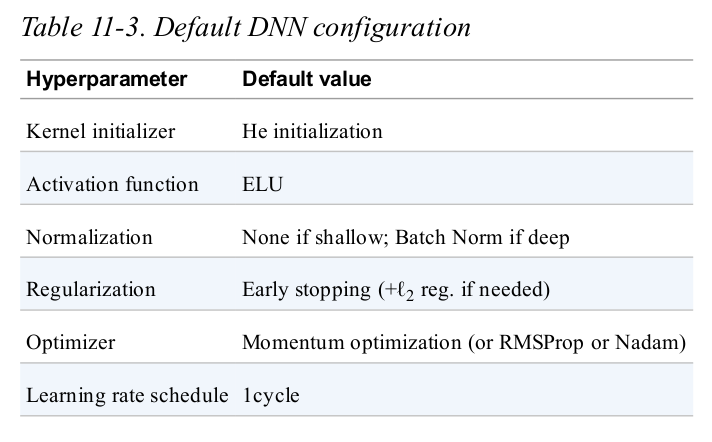

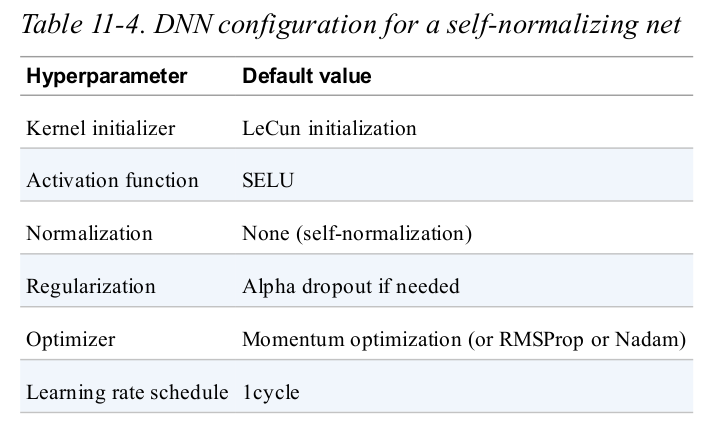

## Exercise

### 8.

Practice training a deep neural network on the CIFAR10 image dataset:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import math

tf.random.set_seed(42)
np.random.seed(42)

2024-01-02 15:16:23.862449: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-02 15:16:23.982358: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-02 15:16:23.983360: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-02 15:16:24.885233: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


a. Build a DNN with 20 hidden layers of 100 neurons each (that’s too many, but it’s the point of this exercise). Use
He initialization and the ELU activation function.

In [2]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32,32,3]))

for _ in range(20):
    model.add(keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"))

b. Using Nadam optimization and early stopping, train the network on the CIFAR10 dataset. You can load it with
`keras.datasets.cifar10.load_data()`. The dataset is composed of 60,000 32 × 32–pixel color images 
(50,000 for training, 10,000 for testing) with 10 classes, so you’ll need a softmax output layer with 10 neurons. Remember to search for the right learning rate each time you change the model’s architecture or hyperparameters.

In [3]:
model.add(keras.layers.Dense(10, activation="softmax"))

In [4]:
optimizer = keras.optimizers.Nadam(learning_rate=5e-5)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
            metrics=["accuracy"])

We also want to use early stopping, so we need a validation set. Let's use the first 5000 images of the original training set as the validation set:

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

In [6]:
X_train_full.shape, X_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [7]:
y_train_full.shape, y_test.shape

((50000, 1), (10000, 1))

In [8]:
y_train_full

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

In [3]:
X_train = X_train_full[5000:]
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000]
y_valid = y_train_full[:5000]

In [10]:
class_labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

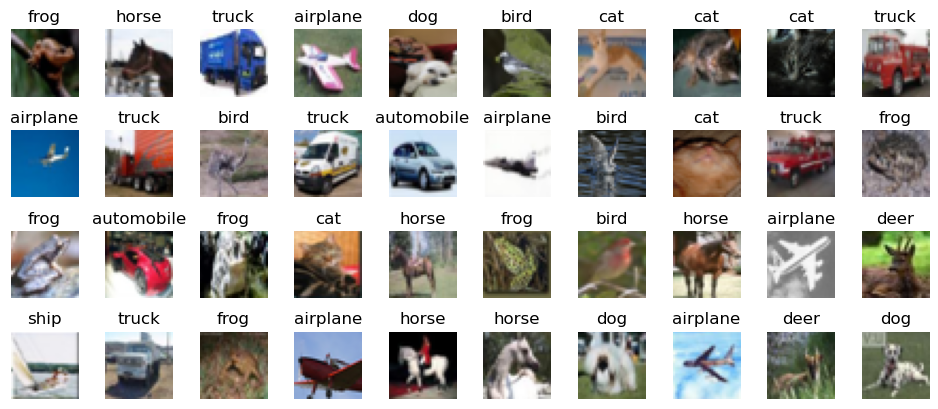

In [11]:
n_cols = 10
n_rows = 4

plt.figure(figsize=(n_cols*1.2, n_rows*1.2))

for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(X_train[index])
        plt.axis("off")
        plt.title(class_labels[y_train[index][0]], fontsize=12)
        
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Now we can create the callbacks and train the model:

In [13]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar_model.h5", save_best_only=True)
run_index = 1 # increment everytime we train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [15]:
h = model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=callbacks, batch_size=32)

Epoch 1/100


2024-01-02 12:11:08.313541: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 138240000 exceeds 10% of free system memory.


1407/1407 [==============================] - 31s 18ms/step - loss: 4.6947 - accuracy: 0.1684 - val_loss: 2.1202 - val_accuracy: 0.2310
Epoch 2/100


/home/dell/anaconda3/envs/latest/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1407/1407 [==============================] - 29s 21ms/step - loss: 2.0386 - accuracy: 0.2499 - val_loss: 1.9992 - val_accuracy: 0.2442
Epoch 3/100
1407/1407 [==============================] - 27s 19ms/step - loss: 1.9345 - accuracy: 0.2860 - val_loss: 1.8804 - val_accuracy: 0.3074
Epoch 4/100
1407/1407 [==============================] - 25s 18ms/step - loss: 1.8596 - accuracy: 0.3188 - val_loss: 1.8622 - val_accuracy: 0.3274
Epoch 5/100
1407/1407 [==============================] - 25s 18ms/step - loss: 1.7986 - accuracy: 0.3434 - val_loss: 1.7424 - val_accuracy: 0.3612
Epoch 6/100
1407/1407 [==============================] - 25s 18ms/step - loss: 1.7531 - accuracy: 0.3623 - val_loss: 1.7626 - val_accuracy: 0.3592
Epoch 7/100
1407/1407 [==============================] - 30s 21ms/step - loss: 1.7127 - accuracy: 0.3776 - val_loss: 1.7113 - val_accuracy: 0.3826
Epoch 8/100
1407/1407 [==============================] - 26s 18ms/step - loss: 1.6784 - accuracy: 0.3891 - val_loss: 1.6627 - val_

Now let's visualize the graphs in tensorboard. We can use the following command to launch tensorboard:
```
tensorboard --logdir=./my_cifar10_logs --port=6006
```

In [16]:
model = keras.models.load_model("my_cifar_model.h5")
model.evaluate(X_valid, y_valid)

2024-01-02 12:36:36.566284: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 15360000 exceeds 10% of free system memory.


157/157 [==============================] - 1s 3ms/step - loss: 1.4912 - accuracy: 0.4768


[1.4911773204803467, 0.47679999470710754]

In [23]:
#type: ignore
epoch_of_min_valloss = np.argmin(h.history["val_loss"]) + 1 # because index starts from 0 
epoch_of_min_valloss

41

In [25]:
h.history["val_loss"][epoch_of_min_valloss]

1.5087246894836426

The model with the lowest validation loss gets about 47.67% accuracy on the validation set. It took 41 epoch to reach the lowest validation loss, with  <30 seconds per epoch on CPU (without GPU). Let's see if we can improve performance using Batch Normalization.

c. Now try adding Batch Normalization and compare the learning curves: Is it converging faster than before? Does it produce a better model? How does it affect training speed?

The code below is very similar to the code above, with few changes:

- I added a BN Layer after every Dense Layer (before activation function), except for the output layer. I also added a BN layer before the first hidden layer. 
- Changed the learning rate to 5e-4
- Renamed the run directory to run_bn_* and the model fine name to my_cifar10_bn_model.h5

In [26]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32,32,3]))
model.add(keras.layers.BatchNormalization())

for _ in range(20):
    model.add(keras.layers.Dense(100, kernel_initializer="he_normal"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("elu"))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_bn_model.h5", save_best_only=True)
run_index = 1 # increment everytime you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_bn_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

h_bn = model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=callbacks)

Epoch 1/100


2024-01-02 12:50:57.681756: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 138240000 exceeds 10% of free system memory.


1406/1407 [============================>.] - ETA: 0s - loss: 1.8494 - accuracy: 0.3349

2024-01-02 12:51:47.286805: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 15360000 exceeds 10% of free system memory.
/home/dell/anaconda3/envs/latest/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1407/1407 [==============================] - 51s 23ms/step - loss: 1.8494 - accuracy: 0.3349 - val_loss: 1.6614 - val_accuracy: 0.4070
Epoch 2/100
1407/1407 [==============================] - 28s 20ms/step - loss: 1.6775 - accuracy: 0.4031 - val_loss: 1.5762 - val_accuracy: 0.4418
Epoch 3/100
1407/1407 [==============================] - 29s 21ms/step - loss: 1.6029 - accuracy: 0.4300 - val_loss: 1.5248 - val_accuracy: 0.4586
Epoch 4/100
1407/1407 [==============================] - 29s 20ms/step - loss: 1.5501 - accuracy: 0.4494 - val_loss: 1.4876 - val_accuracy: 0.4636
Epoch 5/100
1407/1407 [==============================] - 29s 21ms/step - loss: 1.5053 - accuracy: 0.4644 - val_loss: 1.4447 - val_accuracy: 0.4888
Epoch 6/100
1407/1407 [==============================] - 29s 21ms/step - loss: 1.4660 - accuracy: 0.4797 - val_loss: 1.4361 - val_accuracy: 0.4916
Epoch 7/100
1407/1407 [==============================] - 29s 21ms/step - loss: 1.4353 - accuracy: 0.4893 - val_loss: 1.4141 - val_

In [27]:
model = keras.models.load_model("my_cifar10_bn_model.h5")
model.evaluate(X_valid, y_valid) #type: ignore

157/157 [==============================] - 1s 4ms/step - loss: 1.3163 - accuracy: 0.5388


[1.3163434267044067, 0.5388000011444092]

In [28]:
#type: ignore
epoch_of_bn_min_valloss = np.argmin(h_bn.history["val_loss"]) + 1 # because index starts from 0 
epoch_of_bn_min_valloss

17

- Is the model converging faster than before? Much faster! The previous model took 41 epochs to reach the lowest validation loss, while this model achieved the same loss in just 5 epochs and continued to improve until the 17th epoch. The BN layers stabilized training and allowed us to use a much larger learning rate, so convergence was much faster.

- Does BN produce a better model? Yes! The final model is much better with 53.88% accuracy instead of 47.67%. It's still not good model, but at least it's much better than before.

- How does BN affect the training speed? Although the model converged much faster, each epoch took approx 30s instead of 20s, because of the extra computations required by the BN layers. But overall, training time was shortened significantly.

d. Try replacing Batch Normalization with SELU, and make the necessary adjustements to ensure the network self-normalizes (i.e., standardize the input features, use LeCun normal initialization, make sure the DNN contains only a sequence of dense layers, etc.).

In [5]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100, kernel_initializer="lecun_normal", activation="selu"))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(learning_rate=7e-4)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_selu_model.h5", save_best_only=True)

run_index = 1 #increment everytime you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_selu_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

h_selu = model.fit(X_train_scaled, y_train, epochs=100, validation_data=(X_valid_scaled, y_valid), callbacks=callbacks)

2024-01-02 13:53:58.402951: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 552960000 exceeds 10% of free system memory.


Epoch 1/100
1407/1407 [==============================] - 27s 13ms/step - loss: 1.9157 - accuracy: 0.3142 - val_loss: 1.7980 - val_accuracy: 0.3538
Epoch 2/100
   1/1407 [..............................] - ETA: 14s - loss: 1.8739 - accuracy: 0.4062

/home/dell/anaconda3/envs/latest/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1407/1407 [==============================] - 18s 13ms/step - loss: 1.7082 - accuracy: 0.3945 - val_loss: 1.6735 - val_accuracy: 0.3944
Epoch 3/100
1407/1407 [==============================] - 18s 13ms/step - loss: 1.6188 - accuracy: 0.4268 - val_loss: 1.6489 - val_accuracy: 0.4148
Epoch 4/100
1407/1407 [==============================] - 18s 13ms/step - loss: 1.5570 - accuracy: 0.4524 - val_loss: 1.6148 - val_accuracy: 0.4416
Epoch 5/100
1407/1407 [==============================] - 18s 13ms/step - loss: 1.5026 - accuracy: 0.4731 - val_loss: 1.5404 - val_accuracy: 0.4576
Epoch 6/100
1407/1407 [==============================] - 18s 13ms/step - loss: 1.4557 - accuracy: 0.4938 - val_loss: 1.5408 - val_accuracy: 0.4548
Epoch 7/100
1407/1407 [==============================] - 17s 12ms/step - loss: 1.4159 - accuracy: 0.5078 - val_loss: 1.5587 - val_accuracy: 0.4572
Epoch 8/100
1407/1407 [==============================] - 18s 13ms/step - loss: 1.3730 - accuracy: 0.5194 - val_loss: 1.4883 - val_

In [6]:
model = keras.models.load_model("my_cifar10_selu_model.h5")
model.evaluate(X_valid_scaled, y_valid) #type: ignore

157/157 [==============================] - 1s 4ms/step - loss: 1.4784 - accuracy: 0.5038


[1.4783544540405273, 0.5037999749183655]

In [8]:
#type: ignore
epoch_of_selu_min_valloss = np.argmin(h_selu.history["val_loss"]) + 1 # because index starts from 0 
epoch_of_selu_min_valloss

16

We got 50.37% accuracy, which is slight better than the original model (47.67%) but not as good as the model with BN (53.88%). However, convergence was almost as fast as with BN model. Took 16 epochs to reach the lowest validation loss, plus each epoch took around 18s. So it's by far the fastest model to train so far.

e. Try regularizing the model with alpha dropout. Then, without retraining your model, see if you can achieve better accuracy using MC Dropout.

In [4]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100, kernel_initializer="lecun_normal", activation="selu"))
model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_alpha_dropout_model.h5", save_best_only=True)

run_index = 1 #increment everytime you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_alpha_dropout_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means)  / X_stds

h_alpha_droput = model.fit(X_train_scaled, y_train, epochs=100, validation_data=(X_valid_scaled, y_valid), callbacks=callbacks)

2024-01-02 14:21:33.468900: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 552960000 exceeds 10% of free system memory.


Epoch 1/100
1407/1407 [==============================] - 29s 15ms/step - loss: 1.9010 - accuracy: 0.3259 - val_loss: 1.7681 - val_accuracy: 0.3884
Epoch 2/100
   1/1407 [..............................] - ETA: 17s - loss: 1.8923 - accuracy: 0.2500

/home/dell/anaconda3/envs/latest/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1407/1407 [==============================] - 18s 13ms/step - loss: 1.6680 - accuracy: 0.4114 - val_loss: 1.6459 - val_accuracy: 0.4140
Epoch 3/100
1407/1407 [==============================] - 18s 13ms/step - loss: 1.5786 - accuracy: 0.4426 - val_loss: 1.5924 - val_accuracy: 0.4358
Epoch 4/100
1407/1407 [==============================] - 18s 13ms/step - loss: 1.5190 - accuracy: 0.4650 - val_loss: 1.5741 - val_accuracy: 0.4626
Epoch 5/100
1407/1407 [==============================] - 18s 12ms/step - loss: 1.4607 - accuracy: 0.4928 - val_loss: 1.5774 - val_accuracy: 0.4720
Epoch 6/100
1407/1407 [==============================] - 18s 13ms/step - loss: 1.4105 - accuracy: 0.5101 - val_loss: 1.5219 - val_accuracy: 0.4716
Epoch 7/100
1407/1407 [==============================] - 18s 13ms/step - loss: 1.3681 - accuracy: 0.5242 - val_loss: 1.5192 - val_accuracy: 0.4808
Epoch 8/100
1407/1407 [==============================] - 18s 13ms/step - loss: 1.3233 - accuracy: 0.5391 - val_loss: 1.5019 - val_

In [5]:
model = keras.models.load_model("my_cifar10_alpha_dropout_model.h5")
model.evaluate(X_valid_scaled, y_valid) #type: ignore

157/157 [==============================] - 1s 4ms/step - loss: 1.4772 - accuracy: 0.5200


[1.4772435426712036, 0.5199999809265137]

In [6]:
#type: ignore
epoch_of_alpha_dropout_min_valloss = np.argmin(h_alpha_droput.history["val_loss"]) + 1 # because index starts from 0 
epoch_of_alpha_dropout_min_valloss

11

The model reaches 52% accuracy on the validation set. That's better than without dropout (47.67%). But it's not as good as the model with BN (53.88%). However, it's much faster to train. Each epoch took 18s, which is faster than the model with BN (30s). Also it took only 11 epochs to reach the lowest validation loss, which is faster than the model with BN (17 epochs).

Let's use MC Dropout now. We will need the `MCAlphaDropout` class

In [7]:
class MCAlphaDroput(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

Now let's create a new model, identical to the one we just trained (with same weights), but with the `MCAlphaDropout` dropout layers, instead of `AlphaDropout` layers. 

In [8]:
mc_model = keras.models.Sequential([
    MCAlphaDroput(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer for layer in model.layers #type: ignore
])

Then let's add a couple utility functions. The first will run the models many times (10 by default) and it will return the mean predicted class probabilities. The second will use the mean probabilites to predict the most likely class for each instance:

In [9]:
def mc_droput_predict_probas(mc_model, X, n_samples=10):
    Y_probas = [mc_model.predict(X) for sample in range(n_samples)]
    return np.mean(Y_probas, axis=0)

def mc_dropout_predict_classes(mc_model, X, n_samples=10):
    Y_probas = mc_droput_predict_probas(mc_model, X, n_samples)
    return np.argmax(Y_probas, axis=1)

Now let's make predictions for all the instances in the validation set, and compute the accuracy score:

In [13]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

y_pred = mc_dropout_predict_classes(mc_model, X_valid_scaled)
accuracy = np.mean(y_pred == y_valid[: , 0])
accuracy

157/157 [==============================] - 1s 3ms/step


0.5198

We got no accuracy improvement in this case (we are still at ~52% accuracy).

So the best model we got so far is the Batch Normalization model.

f. Retrain your model using 1cycle scheduling and see if it improves training speed and model accuracy.

In [8]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100, kernel_initializer="lecun_normal", activation="selu"))
model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.SGD(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [4]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate)) #type: ignore
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor) #type: ignore

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    interations = math.ceil(len(X) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / interations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size, callbacks=[exp_lr])
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses  #type: ignore

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale("log")
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

In [5]:
X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means)  / X_stds

In [6]:
batch_size=128

2024-01-02 15:14:17.908726: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 552960000 exceeds 10% of free system memory.


352/352 [==============================] - 7s 15ms/step - loss: nan - accuracy: 0.1516


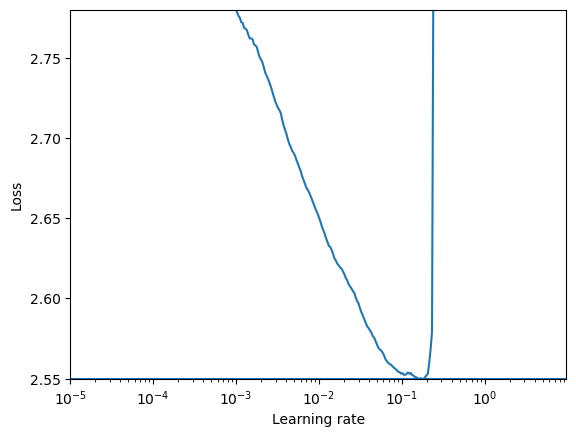

In [9]:
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [7]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None, last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1) / (iter2 - iter1) + rate1)
    
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                    self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                    self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, rate) #type: ignore

In [10]:
min(rates)

1e-05

In [8]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100, kernel_initializer="lecun_normal", activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.SGD(learning_rate=1e-2)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [9]:
n_epochs = 15
onecycle = OneCycleScheduler(math.ceil(len(X_train_scaled) / batch_size) * n_epochs, max_rate=0.05)
h = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size, validation_data=(X_valid_scaled, y_valid), callbacks=[onecycle])

Epoch 1/15


2024-01-02 15:17:30.577230: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 552960000 exceeds 10% of free system memory.


352/352 [==============================] - 5s 10ms/step - loss: 2.0650 - accuracy: 0.2852 - val_loss: 1.7596 - val_accuracy: 0.3846
Epoch 2/15
352/352 [==============================] - 4s 12ms/step - loss: 1.7621 - accuracy: 0.3761 - val_loss: 1.6761 - val_accuracy: 0.4134
Epoch 3/15
352/352 [==============================] - 4s 12ms/step - loss: 1.6293 - accuracy: 0.4222 - val_loss: 1.6204 - val_accuracy: 0.4260
Epoch 4/15
352/352 [==============================] - 4s 12ms/step - loss: 1.5514 - accuracy: 0.4480 - val_loss: 1.6599 - val_accuracy: 0.4306
Epoch 5/15
352/352 [==============================] - 4s 12ms/step - loss: 1.4992 - accuracy: 0.4707 - val_loss: 1.6490 - val_accuracy: 0.4462
Epoch 6/15
352/352 [==============================] - 4s 12ms/step - loss: 1.4594 - accuracy: 0.4843 - val_loss: 1.6075 - val_accuracy: 0.4502
Epoch 7/15
352/352 [==============================] - 4s 12ms/step - loss: 1.4226 - accuracy: 0.4948 - val_loss: 1.5683 - val_accuracy: 0.4488
Epoch 8/15

In [10]:
model.evaluate(X_valid_scaled, y_valid)

157/157 [==============================] - 0s 3ms/step - loss: 1.5754 - accuracy: 0.5204


[1.5753862857818604, 0.5203999876976013]

One cycle allowed us to train the model in just 15 epochs, each epoch taking around 4s (thanks to larger batch size). This is several time faster than the fastest model we trained so far. Morever, performance has reached near to that of BN model, but remember that BN was much slower.

In [11]:
model.evaluate(X_test_scaled, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 1.5709 - accuracy: 0.5224


[1.5708906650543213, 0.5224000215530396]

**Conclusion:**

Batch Normalization is a great technique to accelerate training and improve performance of deep neural networks. However, it does slow down training at runtime. So if we care about runtime latency, we may want to use MC Dropout instead. It will not perform as well as BN, but it will be much faster at runtime. 

Learning rate scheduling can also help speed up training. 

Optimizers such as Nadam and 1cycle can also speed up training considerably.